* Plot radio dynamic spectra from ORFEES and NenuFAR.
* Plot timeseries of STIX, ORFEES, and NenuFAR.

In [2]:
import warnings
warnings.filterwarnings('ignore')
import glob
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import astropy.units as u
from astropy.time import Time
from astropy.io import fits
from sunpy.net import Fido, attrs as a
from sunpy.timeseries import TimeSeries
from radiospectra.spectrogram2 import Spectrogram
from stixpy.net.client import STIXClient  # This registers the STIX client with Fido
from stixpy.product import Product
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.colors import LogNorm
from matplotlib.collections import QuadMesh
import matplotlib as mpl
mpl.rcParams.update({'font.size': 14})
mpl.rcParams['date.epoch'] = '1970-01-01T00:00:00' # use precise epoch
try: mdates.set_epoch('1970-01-01T00:00:00')
except: pass

# import time, os

data_dir = '/home/mnedal/data'

In [3]:
mydate = '2025-03-25'

year, month, day = mydate.split('-')

In [4]:
files = glob.glob(f'{data_dir}/int_orf{year}{month}{day}_*.fts')

orfees = fits.open(files[0])
orfees_i = np.hstack([orfees[2].data[f'STOKESI_B{i}'] for i in range(1, 6)]).T
orfees_data = orfees_i.T

orfees_time_str = orfees[0].header['DATE-OBS']
orfees_times = Time(orfees_time_str) + (orfees[2].data['TIME_B1']/1000)*u.s # times are not the same for all sub spectra!
orfees_freqs = np.hstack([orfees[1].data[f'FREQ_B{i}'] for i in range(1, 6)])*u.MHz

In [5]:
# convert ORFEES data to a DataFrame and plot it to determine the quiet period, which will be divided by later.
df_orfees = pd.DataFrame(data=orfees_data, index=orfees_times, columns=orfees_freqs.value.flatten())
df_orfees.index = [t.datetime for t in df_orfees.index]
df_orfees.head(3)

144.130005   144.520004   144.910004   145.300003   \
2025-03-25 06:56:06.740    38.740002    49.170002    55.987503    53.974998   
2025-03-25 06:56:06.840    40.230003    50.660000    53.490002    52.929996   
2025-03-25 06:56:06.940    47.680000    55.130001    54.782501    53.974998   

                         145.690002   146.960007   148.089996   148.429993   \
2025-03-25 06:56:06.740    55.317501       52.805    53.143330    54.192501   
2025-03-25 06:56:06.840    54.639999       53.625    53.639999    53.817501   
2025-03-25 06:56:06.940    55.472500       54.430    53.639999    54.192501   

                         148.820007   149.210007   ...  990.729980   \
2025-03-25 06:56:06.740    55.035000    54.482498  ...    42.108749   
2025-03-25 06:56:06.840    53.162498    53.737503  ...    42.108749   
2025-03-25 06:56:06.940    53.910000    54.850002  ...    42.108749   

                         992.289978   993.859985   995.419983   996.979980   \
2025-03-25 06:56:06.740    41.434372    46.627499    44.325623    40.367504   
2025-03-25 06:56:06.840    42.340622    46.627499    44.325623    41.341877   
2025-03-25 06:56:06.940    42.787498    46.627499    41.891243    39.887505   

                         998.539978   1000.109985  1001.669983  1003.229980  \
2025-03-25 06:56:06.740    47.371876    46.206249    51.374996    53.906246   
2025-03-25 06:56:06.840    47.371876    47.474998    51.374996    53.906246   
2025-03-25 06:56:06.940    47.371876    47.493752    52.293747    53.906246   

                         1004.700012  
2025-03-25 06:56:06.740    70.457146  
2025-03-25 06:56:06.840    70.457146  
2025-03-25 06:56:06.940    70.457146  

[3 rows x 998 columns]

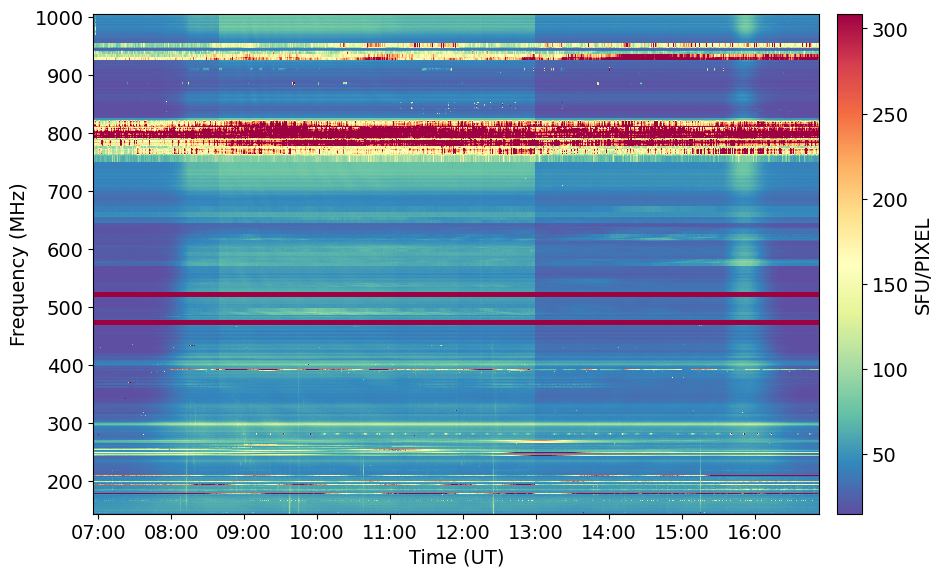

In [26]:
v_range = np.nanpercentile(df_orfees, [1,96])

fig = plt.figure(figsize=[10,6])
ax = fig.add_subplot(111)
pc = ax.pcolormesh(df_orfees.index, df_orfees.columns, df_orfees.T,
                   vmin=v_range[0], vmax=v_range[1], cmap='Spectral_r')
fig.colorbar(pc, ax=ax, pad=0.02, label=orfees[2].header['BUNIT'])
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.tight_layout()
plt.show()

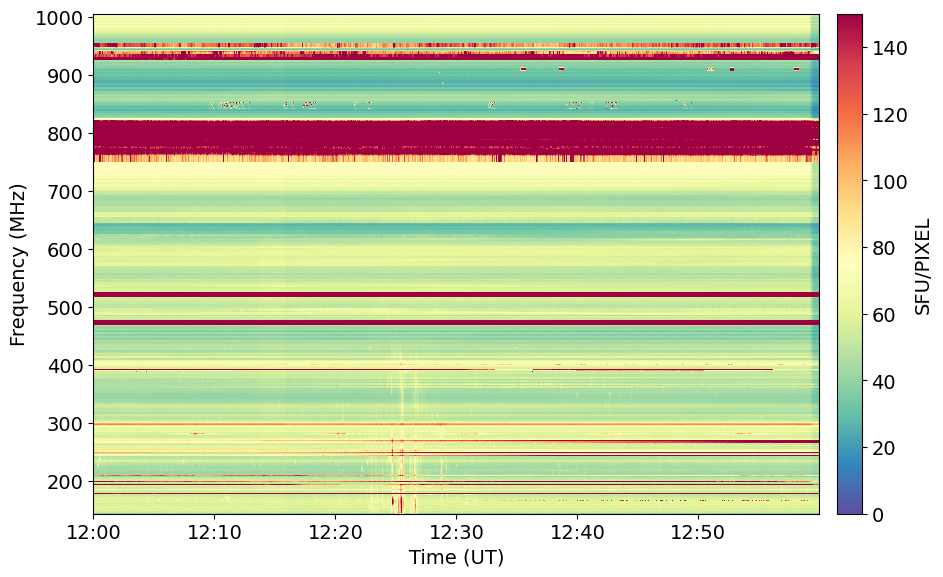

In [79]:
start_time = pd.to_datetime('2025-03-25T12:00:00')
end_time   = pd.to_datetime('2025-03-25T13:00:00')

start_nearest = df_orfees.index.asof(start_time)
end_nearest   = df_orfees.index.asof(end_time)

df_sliced = df_orfees.loc[start_nearest:end_nearest]

fig = plt.figure(figsize=[10,6])
ax = fig.add_subplot(111)
pc = ax.pcolormesh(df_sliced.index, df_sliced.columns, df_sliced.T,
                   vmin=0, vmax=150, cmap='Spectral_r')
fig.colorbar(pc, ax=ax, pad=0.02, label=orfees[2].header['BUNIT'])
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.tight_layout()
plt.show()

In [89]:
bkg_removal_method = 1

if bkg_removal_method==1:
    print('Find the exact or earlier timestamps, and slice at this window')
    start_time = pd.to_datetime('2025-03-25T07:00:00')
    end_time   = pd.to_datetime('2025-03-25T07:15:00')
    
    start_nearest = df_orfees.index.asof(start_time)
    end_nearest   = df_orfees.index.asof(end_time)
    
    subdf = df_orfees.loc[start_nearest:end_nearest]
    df_sliced = subdf.mean(axis=0)
    # print(start_nearest, end_nearest, sep='\n')
    print('Remove the background by dividing the data by the quiet background')
    df_orfees_nobkg = df_orfees/df_sliced

elif bkg_removal_method==2:
    print('### Find the nearest row to a single timestamp')
    start_time = pd.to_datetime('2025-03-25T07:00:00')
    
    nearest_idx = df_orfees.index.get_indexer([start_time], method='nearest')[0]
    df_sliced = df_orfees.iloc[nearest_idx]
    
    actual_time = df_orfees.index[nearest_idx]
    # print(actual_time)
    print('Remove the background by dividing the data by the quiet background')
    df_orfees_nobkg = df_orfees/df_sliced

Find the exact or earlier timestamps, and slice at this window
Remove the background by dividing the data by the quiet background


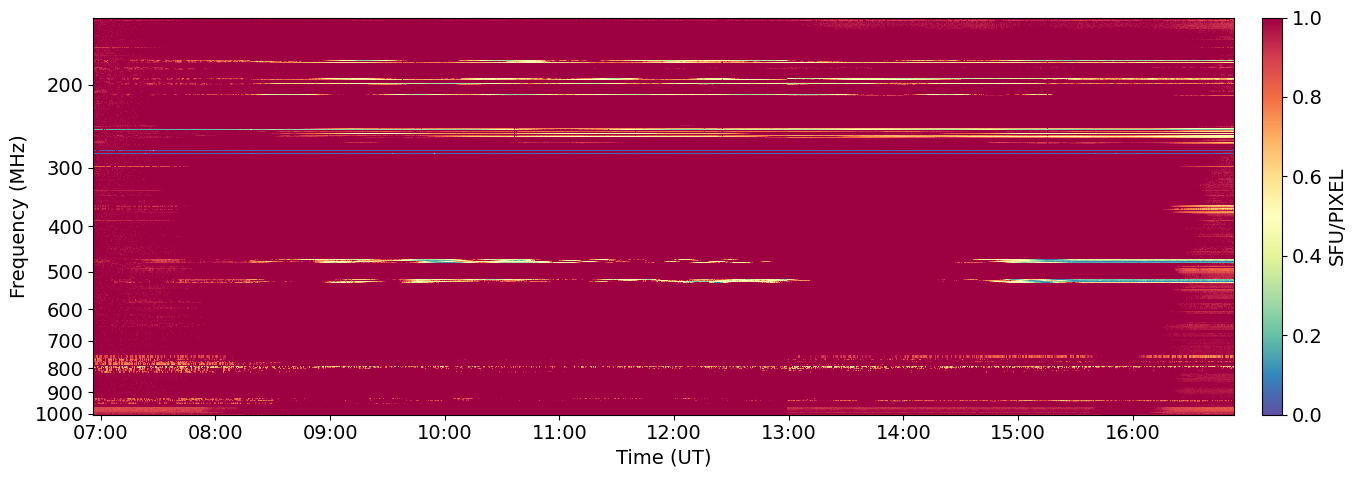

In [91]:
fig = plt.figure(figsize=[15,5])
ax = fig.add_subplot(111)
pc = ax.pcolormesh(df_orfees_nobkg.index, df_orfees_nobkg.columns, df_orfees_nobkg.T,
                   # vmin=v_range[0], vmax=v_range[1],
                   vmin=0, vmax=1,
                   cmap='Spectral_r')
fig.colorbar(pc, ax=ax, pad=0.02, label=orfees[2].header['BUNIT'])
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.set_yscale('log')
ax.set_ylim(ax.get_ylim()[::-1])
yticks = [200, 300, 400, 500, 600, 700, 800, 900, 1000]
ax.set_yticks(yticks)
ax.get_yaxis().set_major_formatter(ticker.FormatStrFormatter('%d'))
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.tight_layout()
plt.show()

In [6]:
df_orfees_1s = df_orfees.resample('1S').mean()

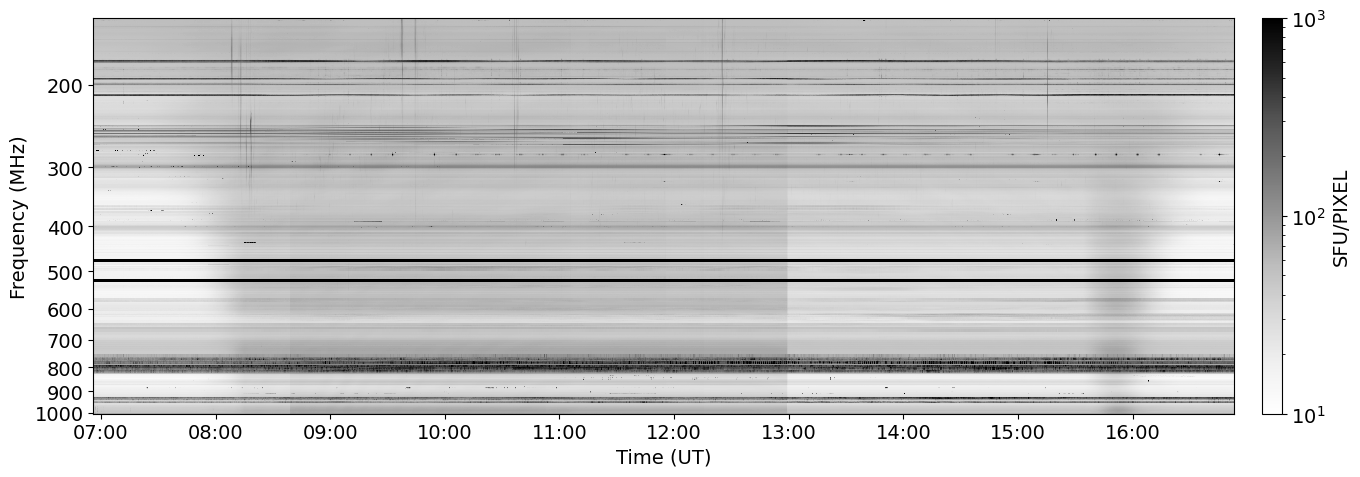

In [118]:
fig = plt.figure(figsize=[15,5])
ax = fig.add_subplot(111)
pc = ax.pcolormesh(df_orfees_1s.index, df_orfees_1s.columns, df_orfees_1s.T,
                   norm=LogNorm(vmin=1e1, vmax=1e3),
                   # norm=LogNorm(vmin=np.nanpercentile(df_orfees_1s, 0), vmax=np.nanpercentile(df_orfees_1s, 90)),
                   cmap='Greys')
fig.colorbar(pc, ax=ax, pad=0.02, label=orfees[2].header['BUNIT'])
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.set_yscale('log')
ax.set_ylim(ax.get_ylim()[::-1])
yticks = [200, 300, 400, 500, 600, 700, 800, 900, 1000]
ax.set_yticks(yticks)
ax.get_yaxis().set_major_formatter(ticker.FormatStrFormatter('%d'))
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.tight_layout()
plt.show()

## Load NenuFAR data

In [63]:
nenufar_files = sorted(glob.glob('/home/mnedal/outputs/data/*'))
nenufar_files

['/home/mnedal/outputs/data/combined_spectra_2025-03-25_typeII.pkl',
 '/home/mnedal/outputs/data/combined_spectra_2025-03-25_typeIII_G1.pkl',
 '/home/mnedal/outputs/data/combined_spectra_2025-03-25_typeIII_G2.npz',
 '/home/mnedal/outputs/data/combined_spectra_2025-03-25_typeIII_G3.npz',
 '/home/mnedal/outputs/data/combined_spectra_2025-03-25_typeIII_G4.pkl']

In [64]:
df_nenufar = pd.read_pickle(nenufar_files[4])

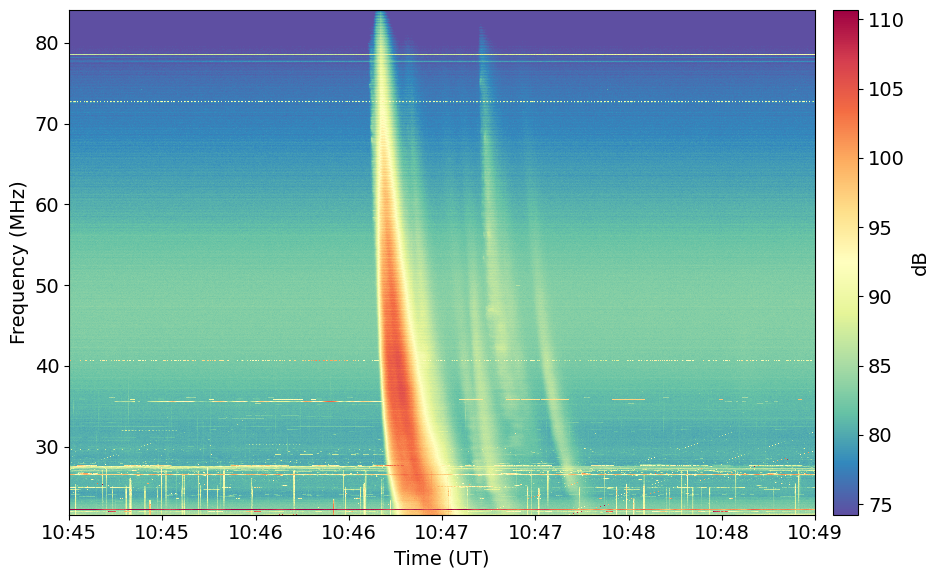

In [129]:
v_range = np.nanpercentile(df_nenufar, [7, 99.97])

fig = plt.figure(figsize=[10,6])
ax = fig.add_subplot(111)
pc = ax.pcolormesh(df_nenufar.index, df_nenufar.columns, df_nenufar.T,
                   vmin=v_range[0], vmax=v_range[1], cmap='Spectral_r')
fig.colorbar(pc, ax=ax, pad=0.02, label='dB')
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.tight_layout()
plt.show()

In [77]:
np.diff(df_nenufar.index)/np.timedelta64(1,'ms')

array([20.971, 20.972, 20.971, ..., 20.972, 20.971, 20.971])

In [73]:
np.mean(np.diff(df_nenufar.index)/np.timedelta64(1,'ms'))

20.97151992310381

20.972

In [65]:
df_nenufar.shape

(11445, 10240)

In [66]:
df_nenufar.index[0], df_nenufar.index[-1]

(Timestamp('2025-03-25 10:45:00.001964'),
 Timestamp('2025-03-25 10:49:00.000038'))

In [132]:
# slice nenufar to match orfees
start_time = pd.to_datetime(df_nenufar.index[0])
end_time   = pd.to_datetime(df_nenufar.index[-1])

start_nearest = df_orfees.index.asof(start_time)
end_nearest   = df_orfees.index.asof(end_time)

subdf_orfees = df_orfees.loc[start_nearest:end_nearest]
subdf_orfees.index[0], subdf_orfees.index[-1]

(Timestamp('2025-03-25 10:44:59.940000'),
 Timestamp('2025-03-25 10:48:59.940000'))

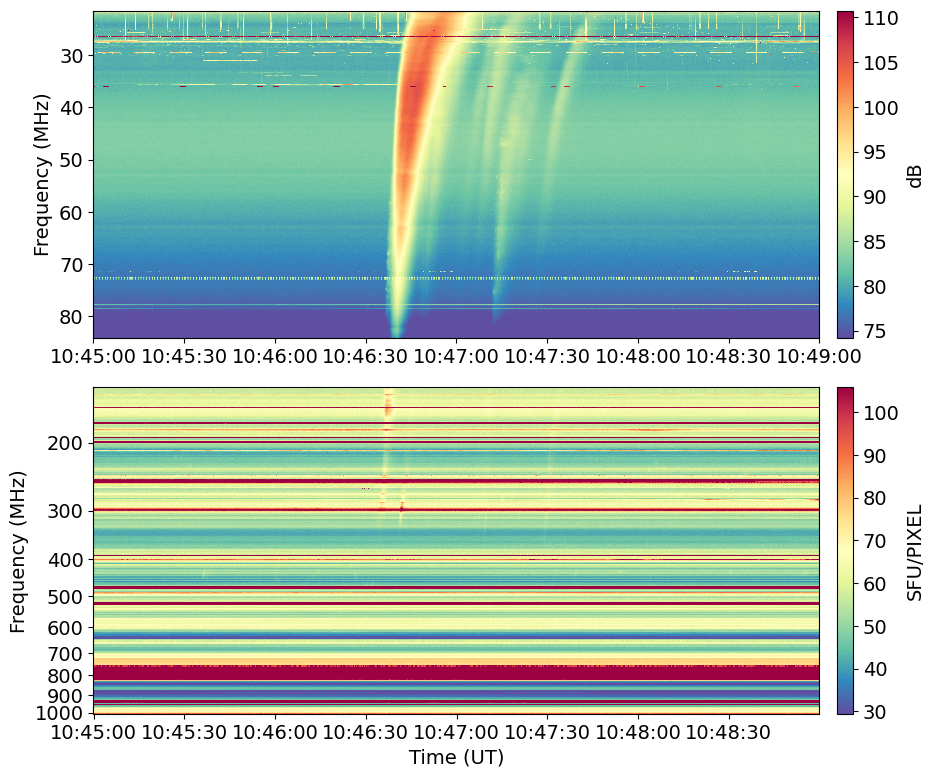

In [135]:
fig = plt.figure(figsize=[10,8])

v_range = np.nanpercentile(df_nenufar, [7, 99.97])
ax = fig.add_subplot(211)
pc = ax.pcolormesh(df_nenufar.index, df_nenufar.columns, df_nenufar.T,
                   vmin=v_range[0], vmax=v_range[1], cmap='Spectral_r')
fig.colorbar(pc, ax=ax, pad=0.02, label='dB')
ax.set_ylabel('Frequency (MHz)')
ax.set_ylim(ax.get_ylim()[::-1])
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

v_range = np.nanpercentile(subdf_orfees, [1, 90])
ax = fig.add_subplot(212)
pc = ax.pcolormesh(subdf_orfees.index, subdf_orfees.columns, subdf_orfees.T,
                   vmin=v_range[0], vmax=v_range[1], cmap='Spectral_r')
fig.colorbar(pc, ax=ax, pad=0.02, label=orfees[2].header['BUNIT'])
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.set_yscale('log')
ax.set_ylim(ax.get_ylim()[::-1])
yticks = [200, 300, 400, 500, 600, 700, 800, 900, 1000]
ax.set_yticks(yticks)
ax.get_yaxis().set_major_formatter(ticker.FormatStrFormatter('%d'))
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

fig.tight_layout()
plt.show()

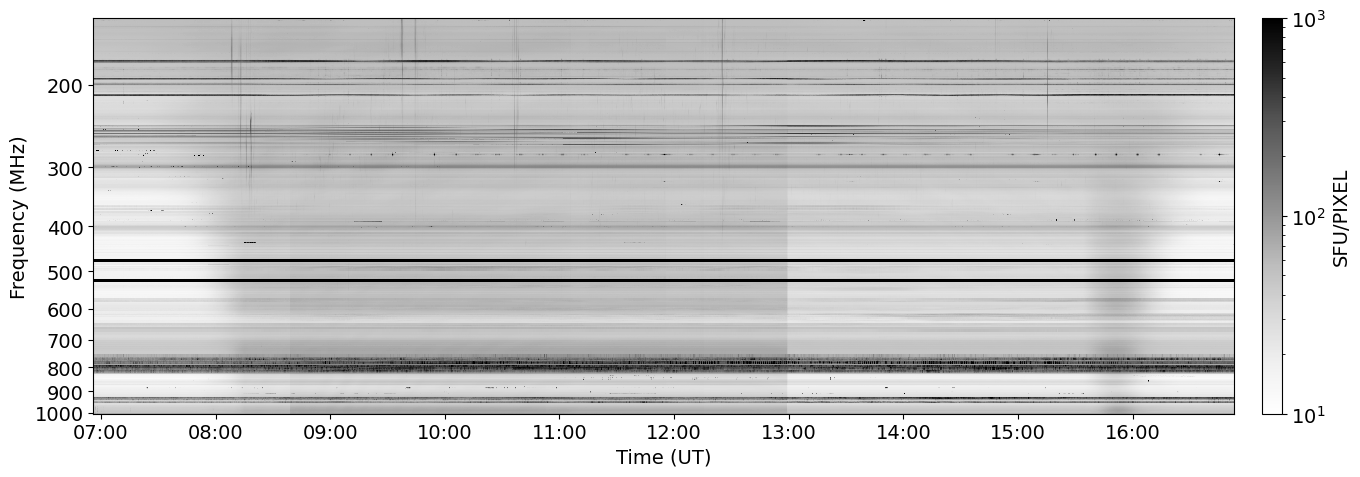

In [7]:
fig = plt.figure(figsize=[15,5])
ax = fig.add_subplot(111)
pc = ax.pcolormesh(df_orfees_1s.index, df_orfees_1s.columns, df_orfees_1s.T,
                   norm=LogNorm(vmin=1e1, vmax=1e3), cmap='Greys')
fig.colorbar(pc, ax=ax, pad=0.02, label=orfees[2].header['BUNIT'])
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.set_yscale('log')
ax.set_ylim(ax.get_ylim()[::-1])
yticks = [200, 300, 400, 500, 600, 700, 800, 900, 1000]
ax.set_yticks(yticks)
ax.get_yaxis().set_major_formatter(ticker.FormatStrFormatter('%d'))
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.tight_layout()
plt.show()

### Option 1: Use a single reference level (e.g., median of all values)

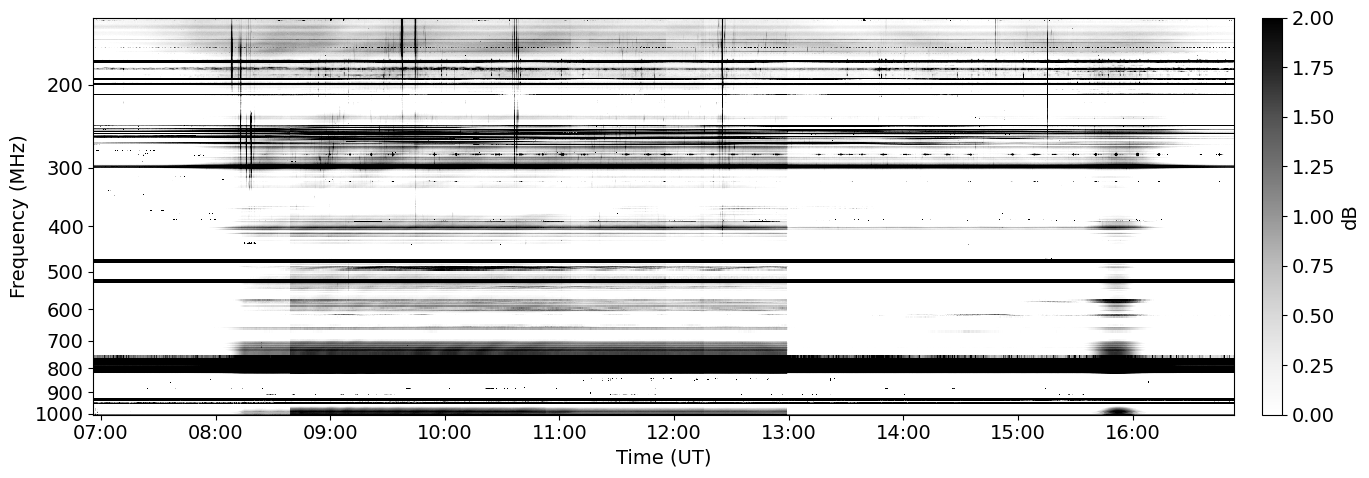

In [17]:
# Avoid log(0) or log of negative numbers
sfu_data_clipped = df_orfees_1s.clip(lower=1e-10)

# Global reference (e.g., median of entire dataset)
P_ref = sfu_data_clipped.median().median()

# Convert to dB
db_data = 10 * np.log10(sfu_data_clipped / P_ref)

# Clean up result
db_data.replace([-np.inf, np.inf], np.nan, inplace=True)

fig = plt.figure(figsize=[15,5])
ax = fig.add_subplot(111)
pc = ax.pcolormesh(db_data.index, db_data.columns, db_data.T,
                   vmin=0, vmax=2, cmap='Greys')
fig.colorbar(pc, ax=ax, pad=0.02, label='dB')
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.set_yscale('log')
ax.set_ylim(ax.get_ylim()[::-1])
yticks = [200, 300, 400, 500, 600, 700, 800, 900, 1000]
ax.set_yticks(yticks)
ax.get_yaxis().set_major_formatter(ticker.FormatStrFormatter('%d'))
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.tight_layout()
plt.show()

### Option 2: Use a reference per frequency (i.e., per column)

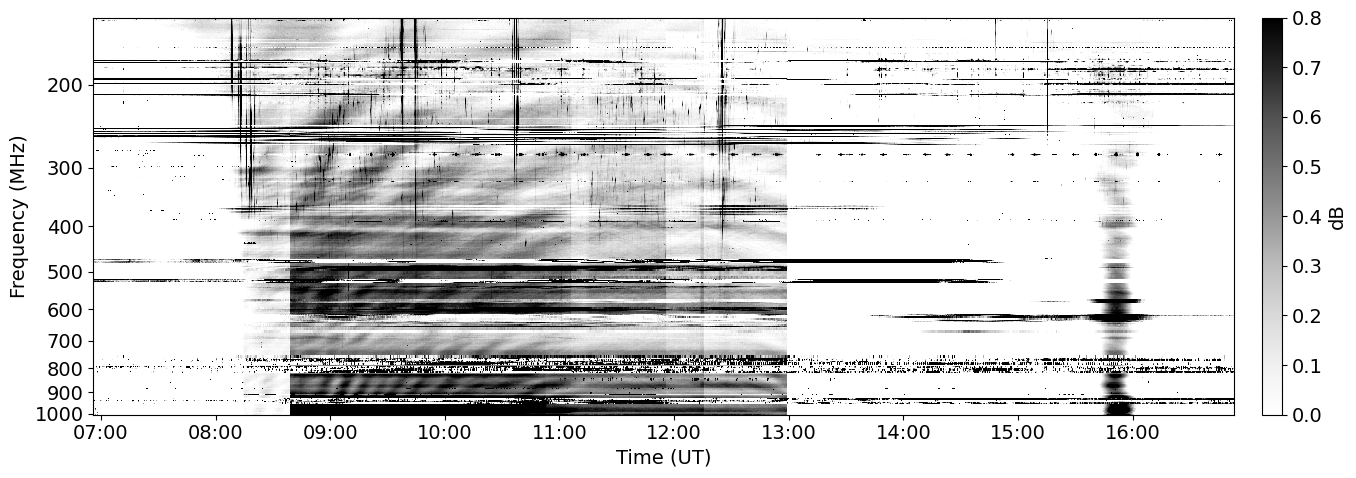

In [48]:
# Avoid log(0) or log of negative numbers
sfu_data_clipped = df_orfees_1s.clip(lower=1e-10)

# Column-wise (per frequency) reference: median per column
P_ref_per_freq = sfu_data_clipped.median(axis=0)  # Series of shape (num_columns,)

# Broadcasting across rows
db_data = 10 * np.log10(sfu_data_clipped.div(P_ref_per_freq, axis='columns'))

# Clean up result
db_data.replace([-np.inf, np.inf], np.nan, inplace=True)

fig = plt.figure(figsize=[15,5])
ax = fig.add_subplot(111)
pc = ax.pcolormesh(db_data.index, db_data.columns, db_data.T,
                   vmin=0, vmax=0.8, cmap='Greys')
fig.colorbar(pc, ax=ax, pad=0.02, label='dB')
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.set_yscale('log')
ax.set_ylim(ax.get_ylim()[::-1])
yticks = [200, 300, 400, 500, 600, 700, 800, 900, 1000]
ax.set_yticks(yticks)
ax.get_yaxis().set_major_formatter(ticker.FormatStrFormatter('%d'))
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.tight_layout()
plt.show()

In [20]:
# Downsample to 1-min resolution
df_orfees_1min = db_data.resample('1min').mean()

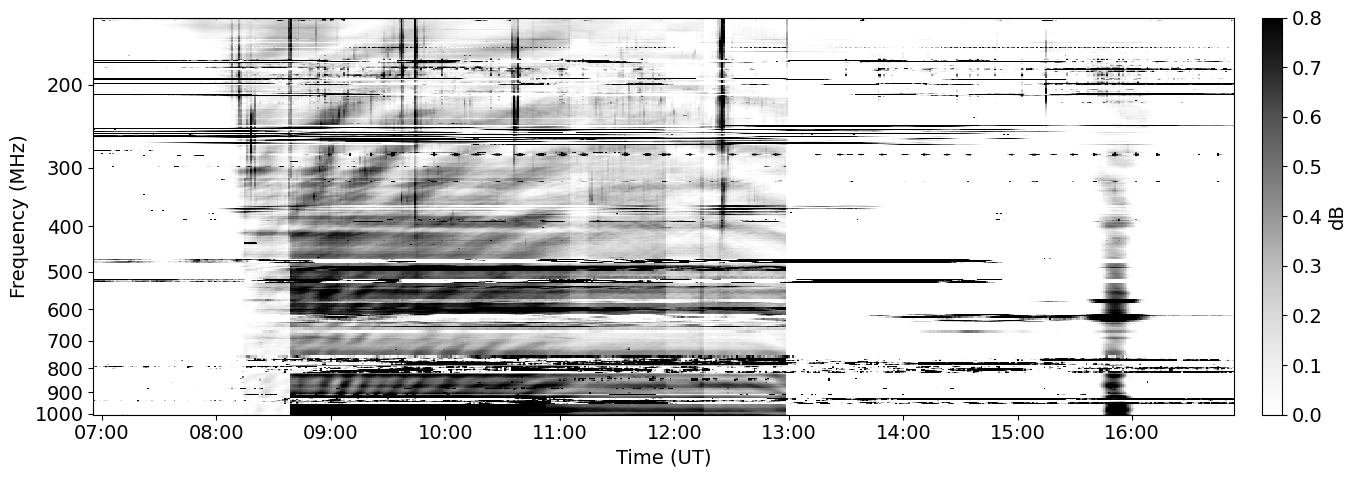

In [46]:
v_range = np.nanpercentile(df_orfees_1min, [50,96])

fig = plt.figure(figsize=[15,5])
ax = fig.add_subplot(111)
pc = ax.pcolormesh(df_orfees_1min.index, df_orfees_1min.columns, df_orfees_1min.T,
                   # vmin=v_range[0], vmax=v_range[1],
                   vmin=0, vmax=0.8,
                   cmap='Greys')
fig.colorbar(pc, ax=ax, pad=0.02, label='dB')
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.set_yscale('log')
ax.set_ylim(ax.get_ylim()[::-1])
yticks = [200, 300, 400, 500, 600, 700, 800, 900, 1000]
ax.set_yticks(yticks)
ax.get_yaxis().set_major_formatter(ticker.FormatStrFormatter('%d'))
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.tight_layout()
plt.show()

In [62]:
np.median(np.diff(df_orfees.index)/np.timedelta64(1,'ms')).astype('int')

100

# Calibration Strategy

## 1. Downsample NenuFAR in time to match ORFEES time resolution

In [90]:
nenufar_cadence = np.median(np.diff(df_nenufar.index)/np.timedelta64(1,'ms'))
orfees_cadence = np.median(np.diff(df_orfees.index)/np.timedelta64(1,'ms'))#.astype('int')

print(f'Downsampling NenuFAR (dt = {nenufar_cadence} ms) to ORFEES cadence (dt = {orfees_cadence} ms)')

nenufar_db_down = df_nenufar.resample(f'{orfees_cadence}ms').mean()

assert np.median(np.diff(nenufar_db_down.index)/np.timedelta64(1,'ms')) == orfees_cadence, 'NenuFAR cadence does not match ORFEES cadence! Check the resampling.'

Downsampling NenuFAR (dt = 20.972 ms) to ORFEES cadence (dt = 100.0 ms)


## 2. Automatically detect quiet periods

In [133]:
def find_quiet_periods(df, window='10S', quant=0.1, std_thresh=None, use_median=True, iqr_multiplier=1.5):
    """
    Identify quiet times in a radio spectrogram based on low spectral variability.

    Parameters:
        df (pd.DataFrame): 2D data with shape (time, frequency) in SFU units.
        window (str): Rolling window size (e.g., '10S' for 10 seconds).
        quant (float): Quantile to use when estimating std_thresh if not provided.
        std_thresh (float or None): If provided, use this absolute threshold for std.
        use_median (bool): Whether to aggregate std across frequencies using median (more robust) or mean.
        iqr_multiplier (float): Multiplier for IQR if using automated thresholding based on boxplot rule.

    Returns:
        pd.DatetimeIndex: Timestamps of detected quiet periods.
    """
    rolling_std = df.rolling(window).std()
    agg_std = rolling_std.median(axis=1) if use_median else rolling_std.mean(axis=1)

    if std_thresh is None:
        Q1 = agg_std.quantile(0.25)
        Q3 = agg_std.quantile(0.75)
        IQR = Q3 - Q1
        std_thresh = Q1 - iqr_multiplier * IQR

    quiet_times = df.index[agg_std < std_thresh]
    return quiet_times

In [134]:
orfees_sfu = df_orfees.copy()
quiet_orf = find_quiet_periods(orfees_sfu, window='10S', iqr_multiplier=1.5)
quiet_nen = find_quiet_periods(nenufar_db_down, window='10S', iqr_multiplier=1.5)
common_quiet_times = quiet_orf.intersection(quiet_nen)
quiet_time_range = quiet_common[:3]  # use first few overlapping quiet timestamps

In [135]:
quiet_orf

DatetimeIndex(['2025-03-25 06:56:06.840000', '2025-03-25 06:56:06.940000',
               '2025-03-25 06:56:07.040000', '2025-03-25 06:56:07.140000',
               '2025-03-25 06:56:07.240000', '2025-03-25 06:56:07.340000',
               '2025-03-25 06:56:07.440000', '2025-03-25 06:56:07.540000',
               '2025-03-25 06:56:07.640000', '2025-03-25 06:56:07.740000',
               ...
               '2025-03-25 16:53:14.240000', '2025-03-25 16:53:14.340000',
               '2025-03-25 16:53:14.440000', '2025-03-25 16:53:14.540000',
               '2025-03-25 16:53:14.640000', '2025-03-25 16:53:14.740000',
               '2025-03-25 16:53:14.840000', '2025-03-25 16:53:14.940000',
               '2025-03-25 16:53:15.040000', '2025-03-25 16:53:15.140000'],
              dtype='datetime64[ns]', length=14937, freq=None)

In [120]:
quiet_nen

DatetimeIndex(['2025-03-25 15:39:25.440000', '2025-03-25 15:39:25.540000',
               '2025-03-25 15:39:25.640000', '2025-03-25 15:39:25.740000',
               '2025-03-25 15:39:25.840000', '2025-03-25 15:39:25.940000',
               '2025-03-25 15:39:26.040000', '2025-03-25 15:39:26.140000',
               '2025-03-25 15:39:26.240000', '2025-03-25 15:39:26.340000',
               ...
               '2025-03-25 16:50:07.640000', '2025-03-25 16:50:07.740000',
               '2025-03-25 16:50:07.840000', '2025-03-25 16:50:07.940000',
               '2025-03-25 16:50:08.040000', '2025-03-25 16:50:08.140000',
               '2025-03-25 16:50:08.240000', '2025-03-25 16:50:08.340000',
               '2025-03-25 16:50:08.440000', '2025-03-25 16:50:08.540000'],
              dtype='datetime64[ns]', length=3268, freq=None)

In [136]:
common_quiet_times

DatetimeIndex([], dtype='datetime64[ns]', freq='100L')

In [137]:
quiet_time_range

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

In [98]:
nenufar_db_down.shape

(2401, 10240)

In [130]:
0.05*100

5.0

In [100]:
quiet_orf = find_quiet_periods(orfees_sfu, std_thresh=0.5)
quiet_orf

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

In [115]:
orfees_sfu_rolling_std = orfees_sfu.rolling('10S').std().mean(axis=1)
print(orfees_sfu_rolling_std.describe())

count    358291.000000
mean         37.565448
std          48.511478
min           8.114905
25%          20.963390
50%          30.931678
75%          47.558077
max        2478.614920
dtype: float64


In [116]:
nenufar_db_down_rolling_std = nenufar_db_down.rolling('10S').std().mean(axis=1)
print(nenufar_db_down_rolling_std.describe())

count    2400.000000
mean        0.799388
std         1.251941
min         0.102304
25%         0.299941
50%         0.343783
75%         0.664323
max         6.888883
dtype: float64


In [109]:
print(orfees_sfu.index)
print(type(orfees_sfu.index))

DatetimeIndex(['2025-03-25 06:56:06.740000', '2025-03-25 06:56:06.840000',
               '2025-03-25 06:56:06.940000', '2025-03-25 06:56:07.040000',
               '2025-03-25 06:56:07.140000', '2025-03-25 06:56:07.240000',
               '2025-03-25 06:56:07.340000', '2025-03-25 06:56:07.440000',
               '2025-03-25 06:56:07.540000', '2025-03-25 06:56:07.640000',
               ...
               '2025-03-25 16:53:14.940000', '2025-03-25 16:53:15.040000',
               '2025-03-25 16:53:15.140000', '2025-03-25 16:53:15.240000',
               '2025-03-25 16:53:15.340000', '2025-03-25 16:53:15.440000',
               '2025-03-25 16:53:15.540000', '2025-03-25 16:53:15.640000',
               '2025-03-25 16:53:15.740000', '2025-03-25 16:53:15.840000'],
              dtype='datetime64[ns]', length=358292, freq=None)
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [111]:
np.diff(orfees_sfu.index)/np.timedelta64(1,'ms')

array([100., 100., 100., ..., 100., 100., 100.])

In [131]:
def find_quiet_periods(df, window='10S', quant=0.1, std_thresh=None, use_median=True):
    """
    Identify quiet periods in a dynamic radio spectrum based on rolling standard deviation.
    
    Parameters
    ----------
    df : pd.DataFrame
        Dynamic spectrum: shape (timestamps, frequencies).
    window : str, optional
        Rolling window size (e.g., '10S').
    quant : float, optional
        Quantile to use if std_thresh is None (e.g., 0.1 = lowest 10%).
    std_thresh : float, bool, or None, optional
        If float: use directly.
        If None: use quantile threshold.
        If True: auto-compute a threshold from data using interquartile range (IQR)-based filtering.
    use_median : bool, optional
        If True, use median over frequencies for aggregation (default). Else use mean.

    Returns
    -------
    pd.DatetimeIndex
        Timestamps of quiet periods.
    """
    rolling_std = df.rolling(window).std()
    agg_std = rolling_std.median(axis=1) if use_median else rolling_std.mean(axis=1)

    if std_thresh is True:
        # Automatically infer a threshold using IQR (Interquartile Range)
        q1 = agg_std.quantile(0.25)
        q3 = agg_std.quantile(0.75)
        iqr = q3 - q1
        std_thresh = q1 - 1.5 * iqr  # below this is "very quiet"
    elif std_thresh is None:
        std_thresh = agg_std.quantile(quant)

    quiet_times = df.index[agg_std < std_thresh]
    return quiet_times

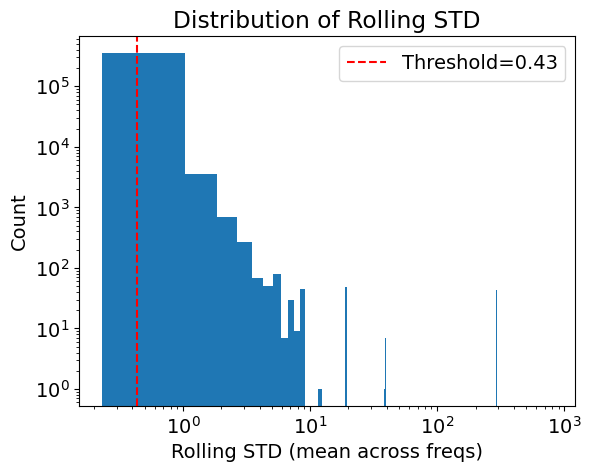

In [129]:
plt.figure()
plt.hist(rolling_std, bins=1000, log=True)
plt.axvline(std_thresh, color='red', linestyle='--', label=f'Threshold={std_thresh:.2f}')
plt.xscale('log')
plt.legend()
plt.xlabel('Rolling STD (mean across freqs)')
plt.ylabel('Count')
plt.title('Distribution of Rolling STD')
plt.show()